## Neural translation model - English to German Translation using seq2seq model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

##Data import

Dataset downlad link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q


In [ ]:
# load the dataset
NUM_EXAMPLES = 20000
data_examples = []
with open('./deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# Preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()


## Text preprocessing

In [ ]:
# separates list of english and german sentences and preprosess them
def get_sentence(data_examples):
    english_sentence = []
    german_sentence = []
    for line in data_examples:
        temp_list = line.strip().split('\t')
        english_sentence.append(preprocess_sentence(temp_list[0]))
      Import the data  german_sentence.append(preprocess_sentence(temp_list[1]))
    return english_sentence, german_sentence

english_sentences, german_sentences = get_sentence(data_examples)

In [ ]:
# Add a special "<start>" and "<end>" token to the beginning and end of every German sentence.
def add_start_and_end_token(german_sentences):
    start_token = '<start> '
    end_token = ' <end>'
    return [start_token + line + end_token for line in german_sentences]

german_sentences_with_token = add_start_and_end_token(german_sentences)

In [ ]:
# tokenize the German sentences
def get_tokenizer(sentences):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    return tokenizer
german_tokenizer = get_tokenizer(german_sentences_with_token)
german_tokenizer_max_index = max(german_tokenizer.index_word.keys())
german_seq = german_tokenizer.texts_to_sequences(german_sentences_with_token)

In [ ]:
# 5 randomly chosen examples of (preprocessed) English and German sentence pairs.
idx = tf.random.uniform((5,), minval=0, maxval=len(german_seq), dtype=tf.int32).numpy()
for i, id in enumerate(idx):
    if i != 0:
        print('\n==================================================================================\n')

    print(f'English translation: {english_sentences[id]}')
    print(f'German translation: {german_sentences_with_token[id]}')
    print(f'German tokenized sequence: {german_seq[id]}')

English translation: that's very big .
German translation: <start> das ist enorm . <end>
German tokenized sequence: [1, 11, 6, 1867, 3, 2]


English translation: we'll be ok .
German translation: <start> wir werden okay sein . <end>
German tokenized sequence: [1, 17, 69, 231, 54, 3, 2]


English translation: i'm all alone now .
German translation: <start> jetzt bin ich ganz allein . <end>
German tokenized sequence: [1, 62, 15, 4, 194, 139, 3, 2]


English translation: they won't know .
German translation: <start> sie werden es nicht wissen . <end>
German tokenized sequence: [1, 8, 69, 10, 12, 191, 3, 2]


English translation: he winked at her .
German translation: <start> er zwinkerte ihr zu . <end>
German tokenized sequence: [1, 14, 1276, 27, 20, 3, 2]


In [ ]:
# Pads the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.
german_padded_seq = tf.keras.preprocessing.sequence.pad_sequences(german_seq, padding='post')
print(f'german_padded_seq.shape = {german_padded_seq.shape}')

german_padded_seq.shape = (20000, 14)


##Data preparation

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer
embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape[0]

7

In [ ]:
# Creates a random training and validation set split of the data, reserving 20% of the data for validation
from sklearn.model_selection import train_test_split

split = train_test_split(english_sentences, german_padded_seq, test_size=0.2)
english_sentences_train, english_sentences_test = split[:2]
german_padded_seq_train, german_padded_seq_test = split[2:]

In [ ]:
# Loads the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
training_dataset = tf.data.Dataset.from_tensor_slices((english_sentences_train, german_padded_seq_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((english_sentences_test, german_padded_seq_test))

In [ ]:
# function to map over the datasets that splits each English sentence at spaces.
def split_english_sentences(dataset):
    def func(english_sentence, german_padded_seq):
        return tf.strings.split(english_sentence), german_padded_seq
    dataset = dataset.map(func)
    return dataset
    
training_dataset = split_english_sentences(training_dataset)
validation_dataset = split_english_sentences(validation_dataset)

In [ ]:
# function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model.
def embed_english_words(dataset, embedding_layer):
    dataset = dataset.map(lambda x,y: (embedding_layer(x), y))
    return dataset
    
training_dataset = embed_english_words(training_dataset, embedding_layer)
validation_dataset = embed_english_words(validation_dataset, embedding_layer)

In [ ]:
# function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length. 
def filter_english_seq(dataset):
    dataset = dataset.filter(lambda x,y: len(x) <= 13)
    return dataset
  
training_dataset = filter_english_seq(training_dataset)
validation_dataset = filter_english_seq(validation_dataset)

In [ ]:
# function to map over the datasets that pads each English sequence of embeddings with 
# some distinct padding value before the sequence, so that each sequence is length 13.
def pad_english_seq(dataset):
    def func(x, y):
        x = tf.pad(x, paddings=[[13 - tf.shape(x)[0], 0],[0,0]], constant_values=0)
        return x,y
    dataset = dataset.map(func)
    return dataset

training_dataset = pad_english_seq(training_dataset)
validation_dataset = pad_english_seq(validation_dataset)

In [ ]:
# Batches both training and validation Datasets with a batch size of 16
def get_batched_dataset(dataset, training=False, batch_size=16):
    if training:
      dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    return dataset
training_batched_dataset = get_batched_dataset(training_dataset, training=True)
validation_batched_dataset = get_batched_dataset(validation_dataset)

In [ ]:
# element_spec property for the training and validation Dataset
print(f'training_batched_dataset.element_spec = {training_batched_dataset.element_spec}')
print(f'validation_batched_dataset.element_spec = {validation_batched_dataset.element_spec}')

training_batched_dataset.element_spec = (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
validation_batched_dataset.element_spec = (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [ ]:
english_batch, german_batch = next(iter(training_batched_dataset.take(1)))

In [ ]:
# shape of the English data example from the training Dataset.
print(f'shape of the English data example = {english_batch.shape}')

shape of the English data example = (16, 13, 128)


In [ ]:
# German data example Tensor from the validation Dataset.
print(f'shape of the German data example = \n{german_batch}')

shape of the German data example = 
[[   1    4   66   60  382    3    2    0    0    0    0    0    0    0]
 [   1    5    6   19 4516    3    2    0    0    0    0    0    0    0]
 [   1    6   11   19 1654    7    2    0    0    0    0    0    0    0]
 [   1    4  503   38 5600  475    3    2    0    0    0    0    0    0]
 [   1   86    8   26  215   29    3    2    0    0    0    0    0    0]
 [   1   13   32 3758    3    2    0    0    0    0    0    0    0    0]
 [   1   11  148   21    3    2    0    0    0    0    0    0    0    0]
 [   1    4  122 2202    3    2    0    0    0    0    0    0    0    0]
 [   1   11    6   19  113    3    2    0    0    0    0    0    0    0]
 [   1   17   69 3741    3    2    0    0    0    0    0    0    0    0]
 [   1 2362   37 1835    3    2    0    0    0    0    0    0    0    0]
 [   1   14 2234 2851    3    2    0    0    0    0    0    0    0    0]
 [   1    5  416  149  368    3    2    0    0    0    0    0    0    0]
 [   1    5  10

## Custom layer


In [ ]:
# layer that takes a batch of English data examples from one of the 
# Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
class EndTokenEmbeddingLayer(tf.keras.layers.Layer):
  
    def __init__(self, **kwargs):
        super(EndTokenEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        initializer = tf.random_normal_initializer()
        self.embedding = tf.Variable(initial_value=initializer(shape=(input_shape[-1],)))

    def call(self, input):
        x = tf.map_fn(lambda x: tf.concat([x, tf.reshape(tf.convert_to_tensor(self.embedding), (1,-1))], axis=0), input)
        return x

In [ ]:
english_batch, german_batch = next(iter(training_batched_dataset.take(1)))
print(f'shape after passing through EndTokenEmbeddingLayer = {EndTokenEmbeddingLayer()(english_batch).shape}')

shape after passing through EndTokenEmbeddingLayer = (16, 14, 128)


## Encoder network

In [ ]:
def get_encoder(input_shape):

    model_input = tf.keras.Input(shape=input_shape, name='input')
    x = EndTokenEmbeddingLayer(name='end_token_embedding_layer')(model_input)
    x = tf.keras.layers.Masking(name='masking_layer')(x)
    output, hidden_state, cell_state = tf.keras.layers.LSTM(512, return_state=True, name='lstm')(x)
    model = tf.keras.models.Model(inputs=model_input, outputs=[hidden_state, cell_state], name='Encoder')
    return model

In [ ]:
encoder = get_encoder((None, 128))

english_batch, german_batch = next(iter(training_batched_dataset.take(1)))

hidden_state, cell_state = encoder(english_batch)

print(f'hidden_state shape: {hidden_state.shape}')
print(f'cell_state shape: {cell_state.shape}')

hidden_state shape: (16, 512)
cell_state shape: (16, 512)


In [ ]:
# model summary for the encoder network.
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 128)]       0         
_________________________________________________________________
end_token_embedding_layer (E (None, None, 128)         128       
_________________________________________________________________
masking_layer (Masking)      (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


##Decoder network

In [ ]:
class Decoder(tf.keras.models.Model):

    def __init__(self, german_tokenizer_max_index,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(german_tokenizer_max_index + 1, 128, mask_zero=True, name='embedding')
        self.lstm = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True, name='lstm')
        self.dense = tf.keras.layers.Dense(german_tokenizer_max_index + 1, name='dense')
        
    def call(self, inputs, hidden_state, cell_state):
        x = self.embedding(inputs)
        x = self.lstm(x, initial_state=[hidden_state, cell_state])
        return self.dense(x[0]), x[1], x[2]

In [ ]:
english_batch, german_batch = next(iter(training_batched_dataset.take(1)))

encoder = get_encoder((None, 128))
hidden_state, cell_state = encoder(english_batch)

decoder = Decoder(german_tokenizer_max_index, name='Decoder')
output, hidden_state, cell_state = decoder(german_batch, hidden_state, cell_state)

print(f'output shape: {output.shape}')
print(f'hidden_state shape: {hidden_state.shape}')
print(f'cell_state shape: {cell_state.shape}')

output shape: (16, 14, 5744)
hidden_state shape: (16, 512)
cell_state shape: (16, 512)


In [ ]:
# model summary for the decoder network
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm (LSTM)                  multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
# function that takes a Tensor batch of German data (as extracted from the 
# training Dataset), and returns a tuple containing German inputs and outputs for the decoder model

def get_german_data(batch_data):
    return batch_data[:,:-1], batch_data[:,1:]

In [ ]:
# computes the forward and backward pass for your translation model.

@tf.function
def propogate(english_input, german_input, german_output, encoder, decoder, loss_fn):

    with tf.GradientTape() as tape:
      encoder_hidden_state, encoder_cell_state = encoder(english_input)
      decoder_return_sequence, _, _ = decoder(german_input, encoder_hidden_state, encoder_cell_state)      
      loss = loss_fn(german_output, decoder_return_sequence)
    return loss, tape.gradient(loss, [encoder.trainable_variables, decoder.trainable_variables])

In [ ]:
# custom training loop

def train(encoder, decoder, num_epochs, training_batched_dataset, validation_batched_dataset, patience):

    training_epochs_losses = []
    validation_epochs_losses = []

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    patience_count = 0
    for i in range(num_epochs):
        
        training_epoch_loss_avg = tf.keras.metrics.Mean()
        validation_epoch_loss_avg = tf.keras.metrics.Mean()

        for english, german in training_batched_dataset.as_numpy_iterator():

            german_input, german_output = get_german_data(german)
            loss, [encoder_gradient, decoder_gradient] = propogate(english, german_input, german_output, encoder, decoder, loss_fn)
            training_epoch_loss_avg(loss)
            optimizer.apply_gradients(zip(encoder_gradient, encoder.trainable_variables))
            optimizer.apply_gradients(zip(decoder_gradient, decoder.trainable_variables))

        for english, german in validation_batched_dataset:

            german_input, german_output = get_german_data(german)
            encoder_hidden_state, encoder_cell_state = encoder(english)
            decoder_return_sequence, _, _ = decoder(german_input, encoder_hidden_state, encoder_cell_state)
            validation_epoch_loss_avg(loss_fn(german_output, decoder_return_sequence))


        validation_epoch_loss = validation_epoch_loss_avg.result().numpy()

        if not validation_epochs_losses or validation_epoch_loss < min(validation_epochs_losses):
            print('saving best weights')
            encoder.save_weights('./encoder/checkpoint')
            decoder.save_weights('./decoder/checkpoint')

        if validation_epochs_losses and validation_epoch_loss > min(validation_epochs_losses):
            patience_count += 1
        else:
            patience_count = 0

        if patience_count > patience:
            break

        validation_epochs_losses.append(validation_epoch_loss)

        training_epoch_loss = training_epoch_loss_avg.result().numpy()
        training_epochs_losses.append(training_epoch_loss)
        

        print(f'epoch: {i+1}/{num_epochs}, loss: {round(training_epoch_loss, 2)}, val_loss: {round(validation_epoch_loss, 2)}')
        if patience_count > patience:
            break
    
    return training_epochs_losses, validation_epochs_losses

In [ ]:
encoder = get_encoder(input_shape=(None, 128))
decoder = Decoder(german_tokenizer_max_index)
num_epochs = 15
patience = 1

training_batched_dataset = get_batched_dataset(training_dataset, training=True)
validation_batched_dataset = get_batched_dataset(validation_dataset)

training_epochs_losses, validation_epoch_losses = train(encoder, decoder, num_epochs, training_batched_dataset, validation_batched_dataset, patience)

saving best weights
epoch: 1/15, loss: 5.320000171661377, val_loss: 4.579999923706055
saving best weights
epoch: 2/15, loss: 4.03000020980835, val_loss: 3.680000066757202
saving best weights
epoch: 3/15, loss: 3.0999999046325684, val_loss: 2.9200000762939453
saving best weights
epoch: 4/15, loss: 2.2799999713897705, val_loss: 2.259999990463257
saving best weights
epoch: 5/15, loss: 1.5700000524520874, val_loss: 1.7200000286102295
saving best weights
epoch: 6/15, loss: 1.0199999809265137, val_loss: 1.350000023841858
saving best weights
epoch: 7/15, loss: 0.6600000262260437, val_loss: 1.149999976158142
saving best weights
epoch: 8/15, loss: 0.46000000834465027, val_loss: 1.0499999523162842
saving best weights
epoch: 9/15, loss: 0.33000001311302185, val_loss: 1.0099999904632568
saving best weights
epoch: 10/15, loss: 0.25, val_loss: 0.9900000095367432
saving best weights
epoch: 11/15, loss: 0.20000000298023224, val_loss: 0.9800000190734863
epoch: 12/15, loss: 0.17000000178813934, val_loss

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

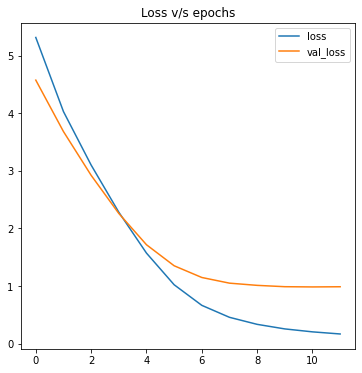

In [ ]:
# loss vs epoch for both training and validation sets.
plt.figure(figsize=(6,6))
plt.plot(training_epochs_losses)
plt.plot(validation_epoch_losses)
plt.legend(['loss', 'val_loss'])
plt.title('Loss v/s epochs');

##Translate

In [ ]:
# five randomly sampled English sentences
english_sentences, german_sentences = get_sentence(data_examples)
idx = tf.random.uniform((5,), minval=0, maxval=len(english_sentences), dtype=tf.int32).numpy()

five_english_sentences , five_german_sentences = [], []

for id in idx:
    five_english_sentences.append(english_sentences[id])
    five_german_sentences.append(german_sentences[id])

In [ ]:
# Preprocess and embed the English sentence according to the model requirements.
test_dataset = tf.data.Dataset.from_tensor_slices((five_english_sentences, five_german_sentences))
test_dataset = split_english_sentences(test_dataset)
test_dataset = embed_english_words(test_dataset, embedding_layer)
test_dataset = filter_english_seq(test_dataset)
test_dadaset = pad_english_seq(test_dataset)
test_dataset = get_batched_dataset(test_dataset, batch_size=1)

In [ ]:
# Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
states = []
for english_data in test_dataset:
    states.append(encoder(english_data))

In [ ]:
# Decode the output token sequence into German text and print the English text and the model's German translation.
start_token = german_tokenizer.word_index['<start>']
end_token = german_tokenizer.word_index['<end>']

for i in range(5):
    if i != 0:
        print('\n==================================================================================\n')
    decoder_output = []
    hidden_state, cell_state = states[i][0], states[i][1]
    token = start_token
    for j in range(14):
      token = tf.constant([[token]], dtype=tf.float32)
      logit, hidden_state, cell_state = decoder(token, hidden_state, cell_state)
      token = tf.argmax(logit[0][0]).numpy()
      if token == end_token:
        break
      decoder_output.append(token)

    print(f'english sentence             : {five_english_sentences[i]}')
    print(f'labeled german translation   : {five_german_sentences[i]}')
    print(f'predicted german translation : {" ".join([german_tokenizer.index_word[token] for token in decoder_output])}')

english sentence             : can it be true ?
labeled german translation   : kann es stimmen ?
predicted german translation : kann es stimmen ?


english sentence             : no one flinched .
labeled german translation   : niemand wich zurueck .
predicted german translation : niemand wich zurueck .


english sentence             : come down here .
labeled german translation   : kommen sie hier herunter !
predicted german translation : komm her .


english sentence             : i worked at it .
labeled german translation   : ich habe daran gearbeitet .
predicted german translation : ich habe das gemacht .


english sentence             : it's inhumane .
labeled german translation   : das ist unmenschlich .
predicted german translation : das ist unmoralisch .
